/var/folders/2d/gpdgqcw134b9wfyg6g2mfw_40000gn/T/ipykernel_1064/3644048291.py:41: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots(figsize=(5, 5))


KeyboardInterrupt: 

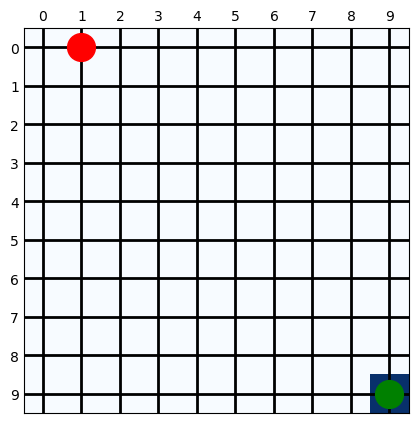

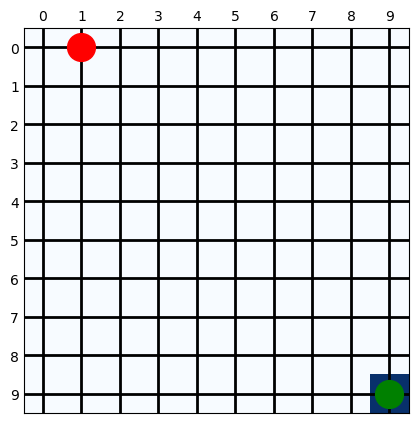

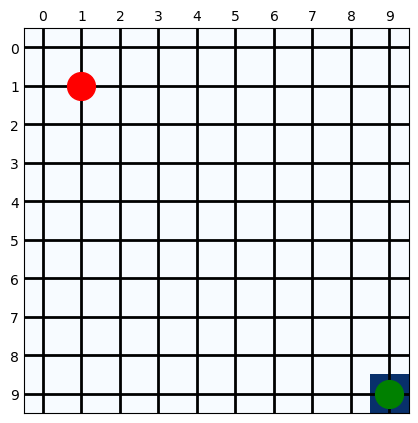

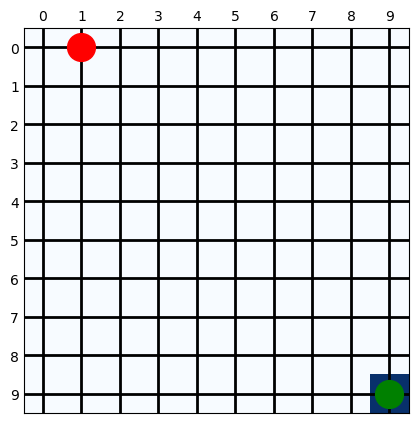

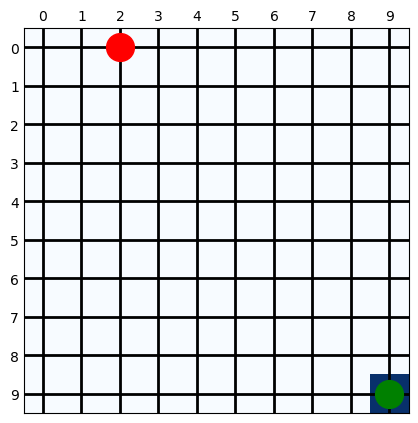

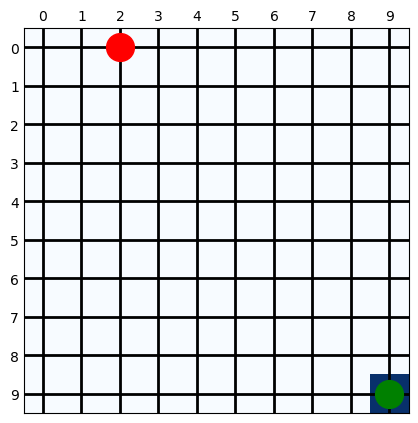

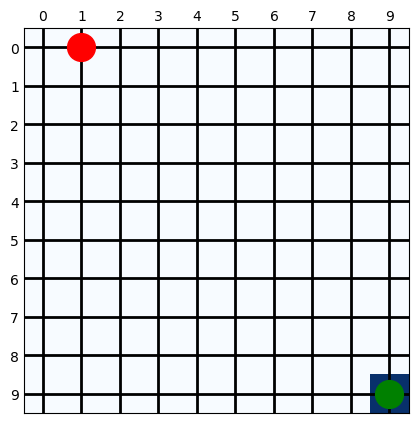

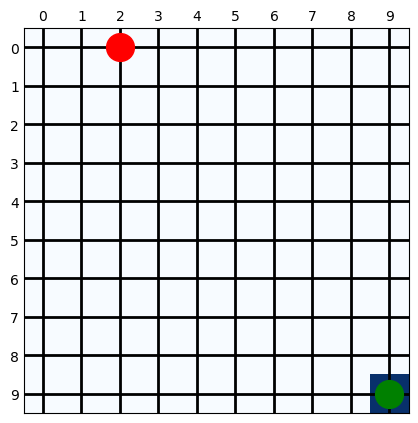

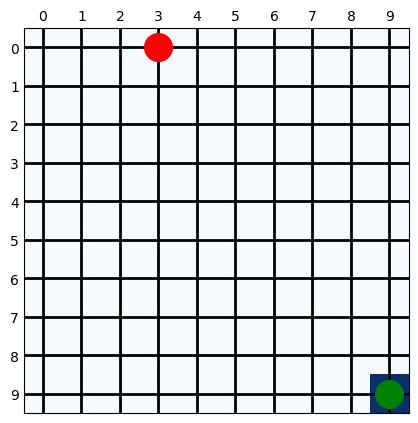

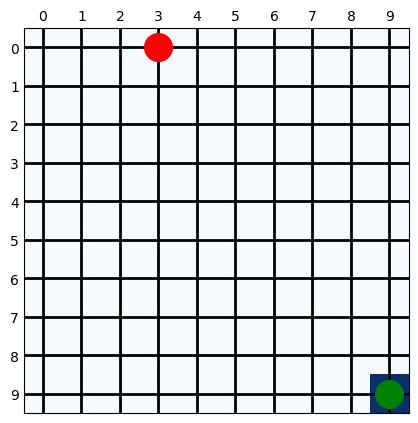

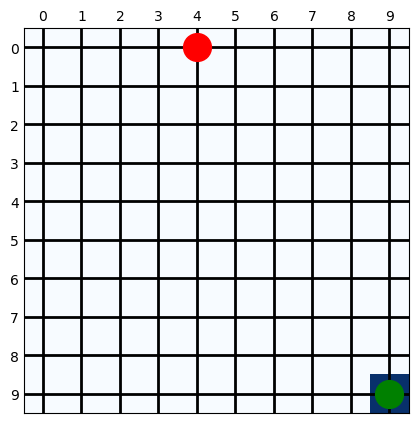

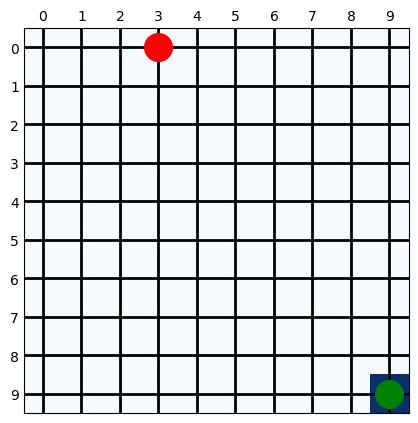

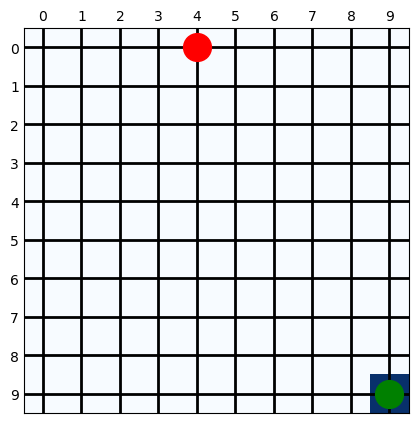

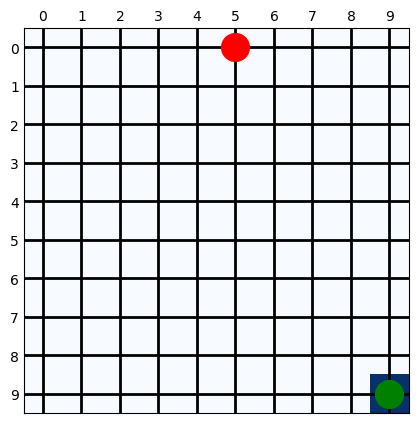

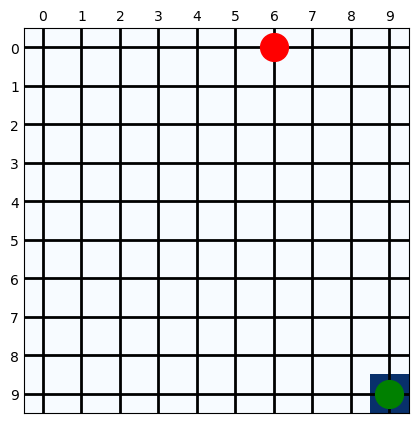

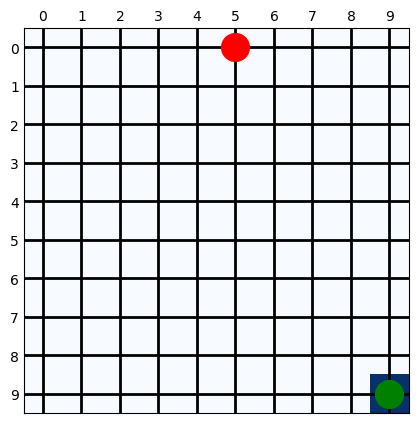

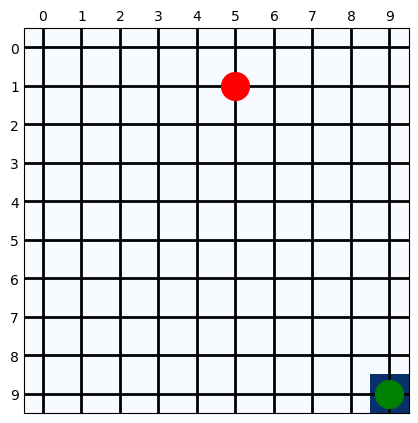

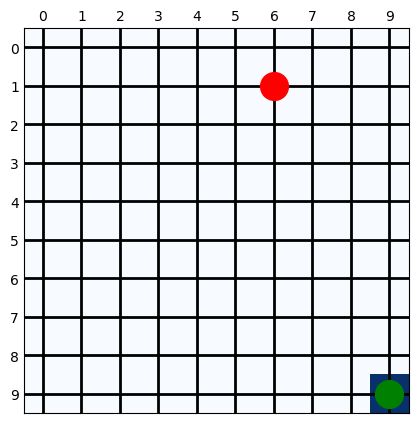

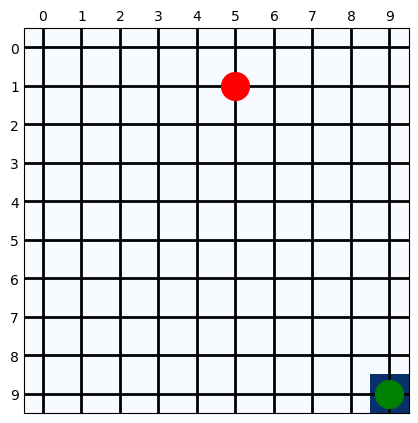

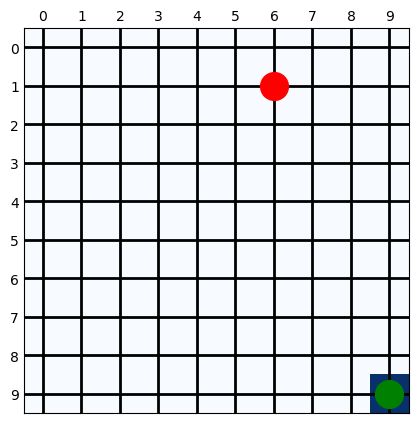

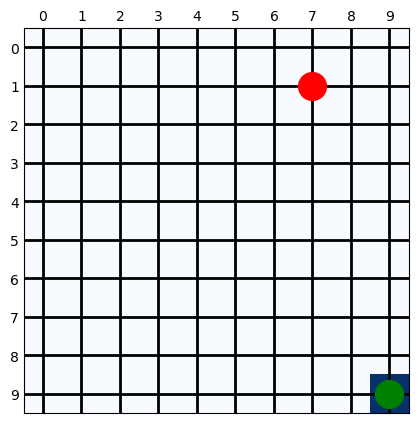

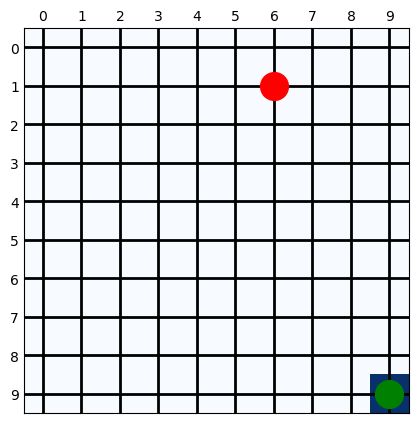

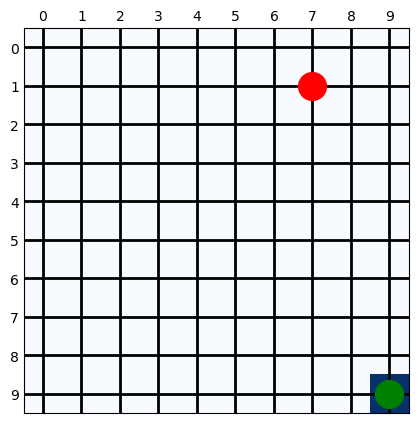

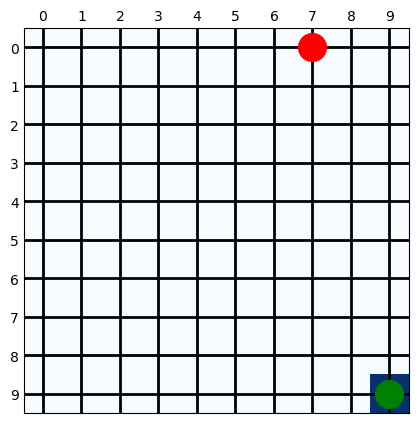

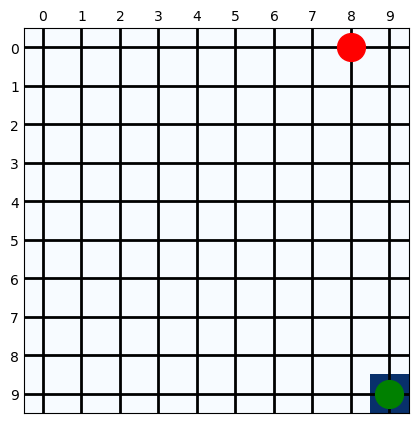

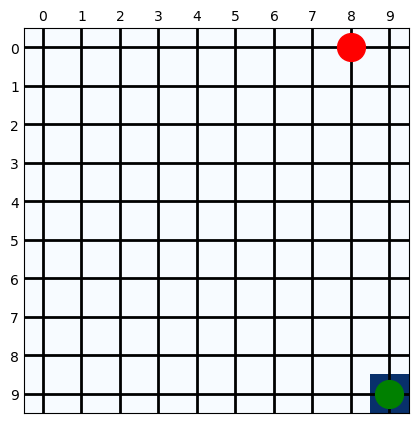

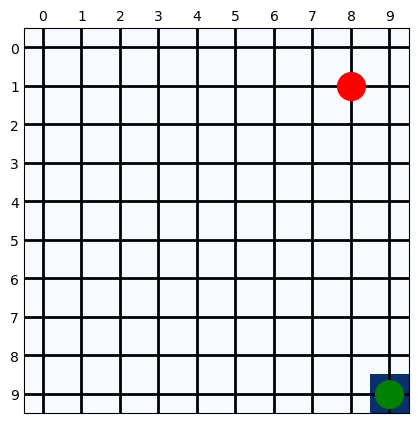

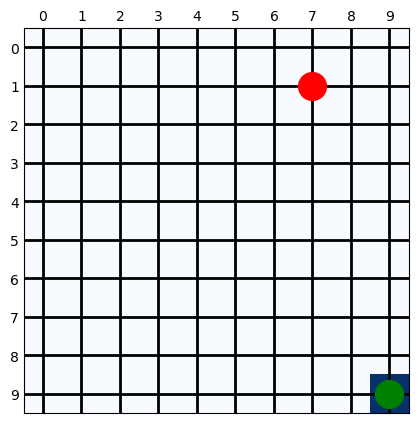

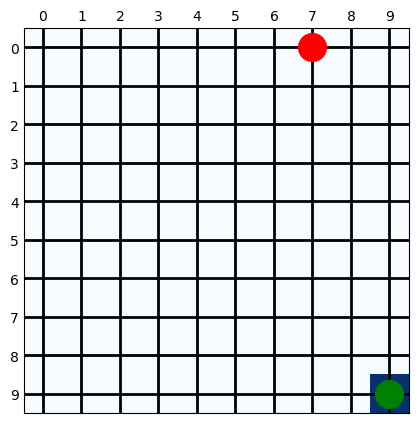

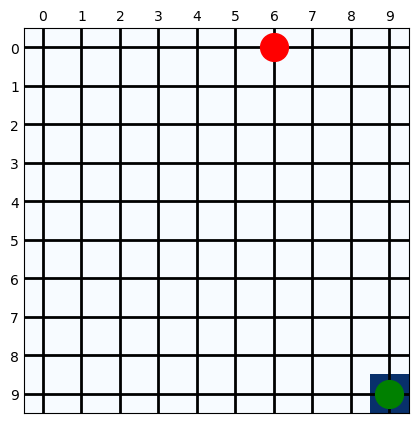

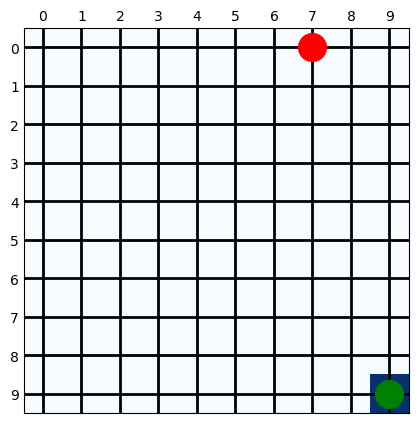

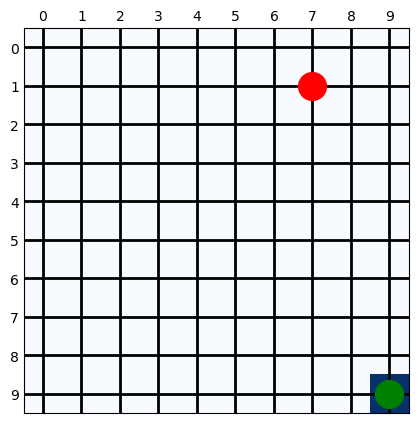

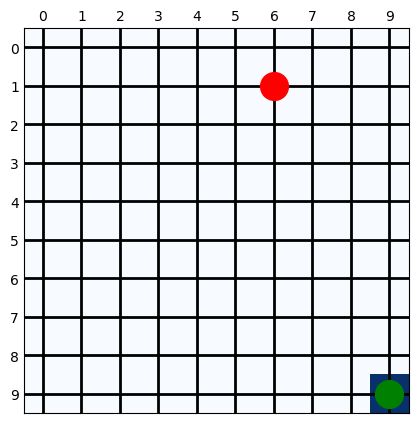

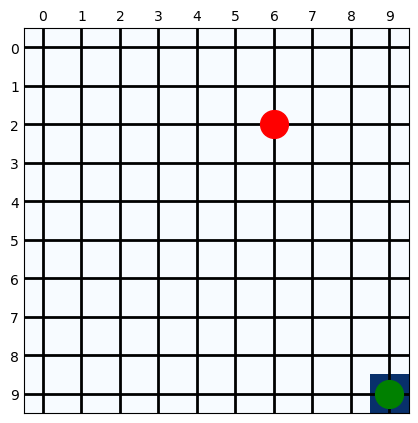

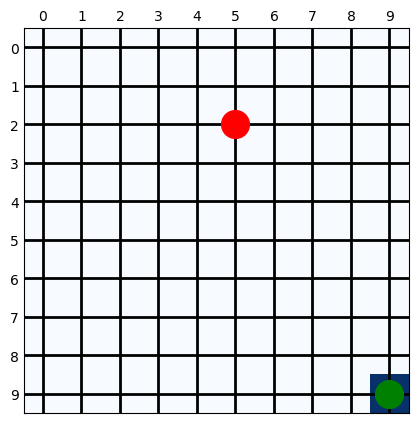

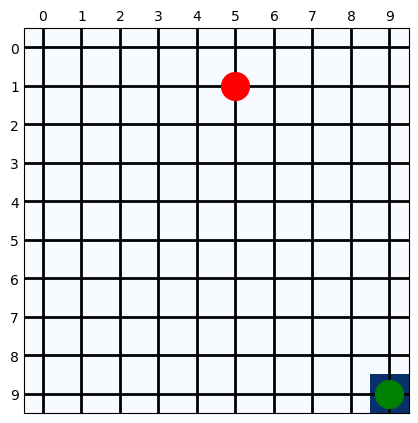

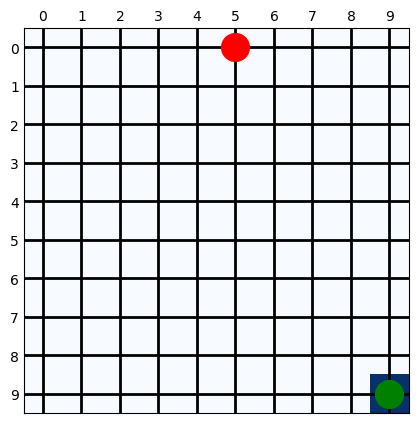

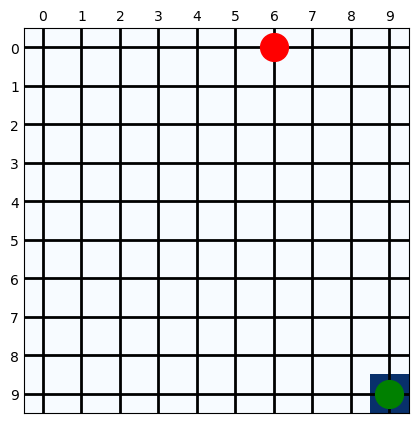

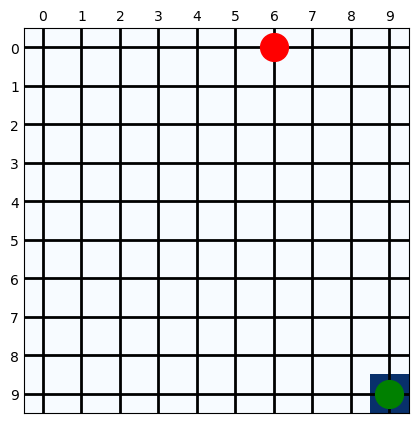

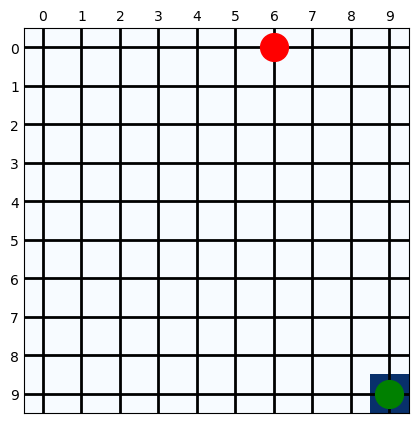

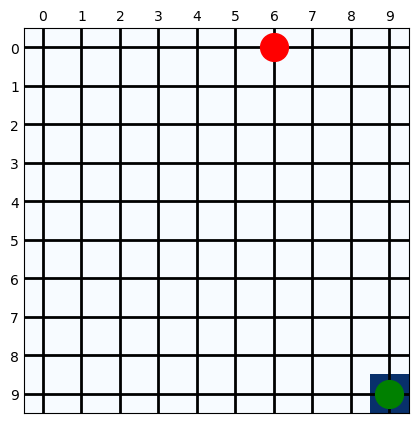

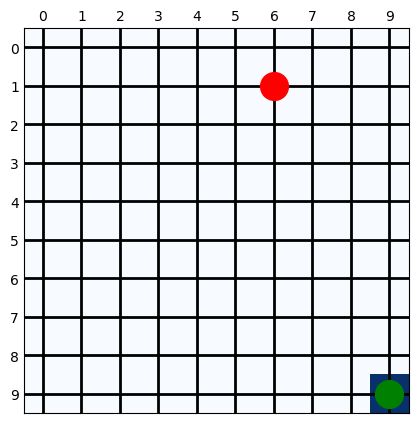

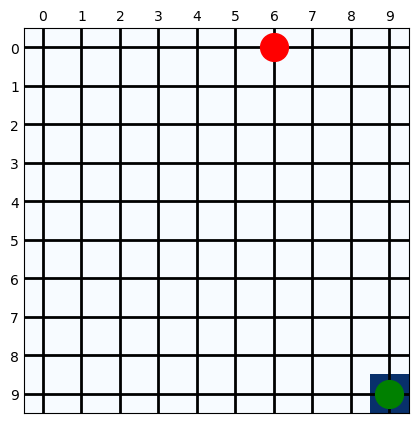

In [13]:
#!/usr/bin/env python
# coding: utf-8

import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import imageio
from PIL import Image

class GridWorld:
    def __init__(self, dim):
        self.dim = dim
        self.agent_pos = (0, 0)
        self.goal_pos = (dim-1, dim-1)
        self.grid = np.zeros((dim, dim))
        self.grid[self.goal_pos] = 1
    
    def step(self, action):
        x, y = self.agent_pos
        if action == 0: # move up
            x = max(x-1, 0)
        elif action == 1: # move down
            x = min(x+1, self.dim-1)
        elif action == 2: # move left
            y = max(y-1, 0)
        elif action == 3: # move right
            y = min(y+1, self.dim-1)
        self.agent_pos = (x, y)
        reward = 0
        done = False
        if self.agent_pos == self.goal_pos:
            reward = 1
            done = True
        return self.agent_pos, reward, done
    
    def reset(self):
        self.agent_pos = (0, 0)
    
    def render(self):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.grid, cmap=plt.cm.Blues)
        ax.set_xticks(range(self.dim))
        ax.set_yticks(range(self.dim))
        ax.tick_params(axis='both', which='both', length=0)
        ax.grid(color='k', linestyle='-', linewidth=2)
        ax.set_axisbelow(True)
        ax.plot(self.goal_pos[1], self.goal_pos[0], 'go', markersize=20)
        ax.plot(self.agent_pos[1], self.agent_pos[0], 'ro', markersize=20)
        # Save the figure to a BytesIO buffer
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)

        # Open the buffer as an image and convert it to an array
        img = Image.open(buf)
        arr = np.array(img)

        return arr

class QLearningAgent:
    def __init__(self, dim, alpha, gamma, epsilon,interest_point,start_point):
        self.dim = dim
        self.alpha = alpha
        self.gamma = gamma
        self.epsilon = epsilon
        self.q_table = np.zeros((dim, dim, 4))
        
    def choose_action(self, state):
        if np.random.uniform(0, 1) < self.epsilon:
            return np.random.randint(0, 4)
        else:
            q_values = self.q_table[state[0], state[1], :]
            max_q_value = np.max(q_values)
            actions = np.argwhere(q_values == max_q_value).flatten()
            return np.random.choice(actions)
        
    def train(self, num_episodes, env):
        rewards = []
        steps = []
        frames = []
        for i in range(num_episodes):
            env.reset()
            state = env.agent_pos
            done = False
            episode_reward = 0
            episode_steps = 0
            while not done:
                action = self.choose_action(state)
                next_state, reward, done = env.step(action)
                q_value = self.q_table[state[0], state[1], action]
                max_next_q_value = np.max(self.q_table[next_state[0], next_state[1], :])
                td_target = reward + self.gamma * max_next_q_value
                td_error = td_target - q_value
                self.q_table[state[0], state[1], action] += self.alpha * td_error
                state = next_state
                episode_reward += reward
                episode_steps += 1

                # Add the current frame to the list of frames
                frames.append(env.render())

            rewards.append(episode_reward)
            steps.append(episode_steps)
            self.epsilon *= 0.99
            if self.epsilon < 0.0001:
                self.epsilon = 0.0001
        return self.q_table, rewards, steps, frames


def main():
    # Create a new gridworld environment
    env = GridWorld(dim=10)

    # Generate random locations for the interest point and starting point
    interest_point = (np.random.randint(0, env.dim), np.random.randint(0, env.dim))
    start_point = (np.random.randint(0, env.dim), np.random.randint(0, env.dim))

    # Create the Q-learning agent
    agent = QLearningAgent(dim=env.dim, epsilon=1, alpha=0.1, gamma=15, interest_point=interest_point, start_point=start_point)

    # Train the agent
    q_table, rewards_per_episode, steps_per_episode, frames = agent.train(num_episodes=3, env=env)

    # Plotting the results
    fig, ax = plt.subplots(nrows=2, figsize=(10, 10))
    ax[0].plot(rewards_per_episode)
    ax[0].set_title('Rewards per episode')
    ax[0].set_xlabel('Episode')
    ax[0].set_ylabel('Total reward')
    ax[1].plot(steps_per_episode)
    ax[1].set_title('Steps per episode')
    ax[1].set_xlabel('Episode')
    ax[1].set_ylabel('Number of steps')

    # Saving the plots
    fig.savefig('plots.png')

    # Creating a video of the trained agent
    with imageio.get_writer('video.mp4', fps=30) as video:
        for frame in frames:
            video.append_data(np.array(frame))

    print("Printed")

main()




In [15]:
import io
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation
import imageio
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim

class GridWorld:
    def __init__(self, dim):
        self.dim = dim
        self.agent_pos = (0, 0)
        self.goal_pos = (dim-1, dim-1)
        self.grid = np.zeros((dim, dim))
        self.grid[self.goal_pos] = 1
    
    def step(self, action):
        x, y = self.agent_pos
        if action == 0: # move up
            x = max(x-1, 0)
        elif action == 1: # move down
            x = min(x+1, self.dim-1)
        elif action == 2: # move left
            y = max(y-1, 0)
        elif action == 3: # move right
            y = min(y+1, self.dim-1)
        self.agent_pos = (x, y)
        reward = 0
        done = False
        if self.agent_pos == self.goal_pos:
            reward = 1
            done = True
        return self.agent_pos, reward, done
    
    def reset(self):
        self.agent_pos = (0, 0)
    
    def render(self):
        fig, ax = plt.subplots(figsize=(5, 5))
        ax.matshow(self.grid, cmap=plt.cm.Blues)
        ax.set_xticks(range(self.dim))
        ax.set_yticks(range(self.dim))
        ax.tick_params(axis='both', which='both', length=0)
        ax.grid(color='k', linestyle='-', linewidth=2)
        ax.set_axisbelow(True)
        ax.plot(self.goal_pos[1], self.goal_pos[0], 'go', markersize=20)
        ax.plot(self.agent_pos[1], self.agent_pos[0], 'ro', markersize=20)
        # Save the figure to a BytesIO buffer
        buf = io.BytesIO()
        fig.savefig(buf, format='png')
        buf.seek(0)

        # Open the buffer as an image and convert it to an array
        img = Image.open(buf)
        arr = np.array(img)

        return arr

class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, output_dim)
        
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class DQNAgent:
    def __init__(self, dim, alpha, gamma, epsilon, interest_point, start_point):
        self.dim = dim
        self.alpha = alpha
        self.gamma = gamma
       
        # Create online and target networks
        online_net = QNetwork(env.dim*env.dim, 4)
        target_net = QNetwork(env.dim*env.dim, 4)
        
        # Define optimizer and loss function
        optimizer = torch.optim.Adam(online_net.parameters(), lr=0.001)
        loss_func = nn.MSELoss()
        
        # Training loop
        rewards = []
        steps = []
        frames = []
        epsilon = 1.0
        update_counter = 0
        for i in range(num_episodes):
            env.reset()
            state = torch.tensor([env.agent_pos[0]*env.dim + env.agent_pos[1]], dtype=torch.float32)
            done = False
            episode_reward = 0
            episode_steps = 0
            while not done:
                action = online_net.choose_action(state, epsilon)
                next_state, reward, done = env.step(action)
                next_state = torch.tensor([next_state[0]*env.dim + next_state[1]], dtype=torch.float32)
                episode_reward += reward
                episode_steps += 1

                # Store experience in replay buffer
                replay_buffer.add(state, action, reward, next_state, done)
                
                state = next_state
                
                # Update online network every UPDATE_FREQUENCY steps
                update_counter += 1
                if update_counter % UPDATE_FREQUENCY == 0:
                    if len(replay_buffer) > BATCH_SIZE:
                        # Sample mini-batch from replay buffer
                        state_batch, action_batch, reward_batch, next_state_batch, done_batch = replay_buffer.sample(BATCH_SIZE)

                        # Convert batch to tensors
                        state_batch = torch.tensor(state_batch, dtype=torch.float32)
                        action_batch = torch.tensor(action_batch, dtype=torch.long).unsqueeze(1)
                        reward_batch = torch.tensor(reward_batch, dtype=torch.float32)
                        next_state_batch = torch.tensor(next_state_batch, dtype=torch.float32)
                        done_batch = torch.tensor(done_batch, dtype=torch.float32)

                        # Update online network
                        optimizer.zero_grad()
                        q_values = online_net(state_batch).gather(1, action_batch)
                        max_next_q_values = target_net(next_state_batch).max(1)[0].unsqueeze(1)
                        td_targets = reward_batch + gamma * max_next_q_values * (1 - done_batch)
                        loss = loss_func(q_values, td_targets.detach())
                        loss.backward()
                        optimizer.step()

                        # Update target network
                        target_net.update_weights(online_net)
                        
            rewards.append(episode_reward)
            steps.append(episode_steps)
            epsilon *= epsilon_decay_rate
            epsilon = max(epsilon, epsilon_min)
            
            # Create video frames
            frames.append(env.render())
            
        return rewards, steps, frames


def create_video(frames):
    # Create video animation
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.set_xticks([])
    ax.set_yticks([])
    img = ax.imshow(frames[0])
    def update_frame(i):
        img.set_array(frames[i])
        return img,

    ani = matplotlib.animation.FuncAnimation(fig, update_frame, frames=len(frames), interval=200)
    
    # Save video to file
    writer = imageio.get_writer('gridworld_video.mp4', fps=5)
    for frame in frames:
        writer.append_data(frame)
    writer.close()
    

if __name__ == '__main__':
    # Create a new gridworld environment
    env = GridWorld(dim=10)

    # Generate random locations for the interest point and starting point
    interest_point = (np.random.randint(0, env.dim), np.random.randint(0, env.dim))

    # Set the interest point and starting point in the environment
    env.set_interest_point(interest_point)
    env.set_agent_pos(starting_point)

    # Run the DQNAgent
    rewards, steps, frames = train_dqn_agent(env, num_episodes=1000, epsilon_decay_rate=0.995, epsilon_min=0.01)

    # Create video animation
    create_video(frames)

    # Plot rewards and steps over episodes
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.subplot(1, 2, 2)
    plt.plot(steps)
    plt.xlabel('Episode')
    plt.ylabel('Total Steps')
    plt.show()



ModuleNotFoundError: No module named 'torch'

In [12]:
import torch

ModuleNotFoundError: No module named 'torch'